In [23]:
import torch
import torch.nn as nn
import numpy as np
from torch.autograd import Variable 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


Data (Input and Ouput)

In [3]:
from google.colab import files
uploaded = files.upload()

Saving valid.csv to valid.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [4]:
import io
df_train = pd.read_csv("train.csv", index_col = "Date", parse_dates=True)
df_valid = pd.read_csv("valid.csv", index_col = "Date", parse_dates=True)
df_test = pd.read_csv("test.csv", index_col = "Date", parse_dates=True)

In [5]:
y_train = df_train.iloc[:,0]
X_train = df_train.iloc[:,1:]

y_test = df_test.iloc[:,0]
X_test = df_test.iloc[:,1:]

y_valid = df_valid.iloc[:,0]
X_valid = df_valid.iloc[:,1:]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 
print("Validate Shape", X_valid.shape, y_valid.shape)

Training Shape (3239, 28) (3239,)
Testing Shape (225, 28) (225,)
Validate Shape (336, 28) (336,)


In [6]:
#Remove strings in data 
# H: win   0
# NHL lose 1
# remove HM1 to AM5

X_train = X_train.drop(['HM1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5'], axis=1)
X_test = X_test.drop(['HM1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5'], axis=1)
X_valid = X_valid.drop(['HM1', 'HM2', 'HM3', 'HM4', 'HM5', 'AM1', 'AM2', 'AM3', 'AM4', 'AM5'], axis=1)

y_train = y_train.replace('H', 1)
y_train = y_train.replace('NH', 0)

y_test = y_test.replace('H', 1)
y_test = y_test.replace('NH', 0)

y_valid = y_valid.replace('H', 1)
y_valid = y_valid.replace('NH', 0)

In [7]:
X_train_tensors = Variable(torch.Tensor(X_train.values))
X_test_tensors = Variable(torch.Tensor(X_test.values))
X_valid_tensors = Variable(torch.Tensor(X_valid.values))

y_train_tensors = Variable(torch.Tensor(y_train.values))
y_test_tensors = Variable(torch.Tensor(y_test.values)) 
y_valid_tensors = Variable(torch.Tensor(y_valid.values))

In [8]:
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

y_train_tensors_final = torch.reshape(y_train_tensors, (y_train_tensors.shape[0], 1))
y_test_tensors_final = torch.reshape(y_test_tensors, (y_test_tensors.shape[0], 1))

print(f"X_train_tensors_final:\n{X_train_tensors_final[:3,:]}\n")

X_train_tensors_final:
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]])



In [14]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors_final.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors_final.shape)

print(X_train_tensors_final)

Training Shape torch.Size([3239, 1, 18]) torch.Size([3239, 1])
Testing Shape torch.Size([225, 1, 18]) torch.Size([225, 1])
tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        ...,

        [[ 0.2451,  0.3143,  0.3373,  ...,  0.3000, -0.4000, -0.0500]],

        [[ 0.4608,  0.2762,  0.1687,  ...,  0.2500,  1.2500,  0.2500]],

        [[ 0.5098,  0.2190,  0.2771,  ...,  0.3000,  0.4500, -0.0500]]])


LSTM Model Architecture

In [24]:
class rnnLSTM(nn.Module):

  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    
    super(rnnLSTM, self).__init__()
    self.num_classes = num_classes
    self.num_layers = num_layers
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.seq_length = seq_length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.fc_1 = nn.Linear(hidden_size, 128)
    self.fc_2 = nn.Linear(128, num_classes)
    self.relu = nn.ReLU()

  def forward(self, x):
    
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

    output, (hn, cn) = self.lstm(x, (h_0, c_0))
    hn = hn.view(-1, self.hidden_size) #reshaping data for Dense layer
    out = self.relu(hn)
    out = self.fc_1(out)
    out = self.relu(out)
    out = self.fc_2(out)

    return out

Initializing LSTM Model

In [25]:
num_epochs = 100
learning_rate = 0.001

input_size = 18 #Number of features
hidden_size = 5 #Number of features in Short Term memory (hidden state)
num_layers = 1 #Number of stacked LSTM layers
num_classes = 2 #number of output classes
lstm1 = rnnLSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1])

Training (Implement Batches)

Epoch 1: Train acc: 0.5541833899351651 Losses: 0.6930657029151917
Epoch 2: Train acc: 0.552639703612226 Losses: 0.6910938024520874
Epoch 3: Train acc: 0.5625192960790367 Losses: 0.6892340183258057
Epoch 4: Train acc: 0.5739425748687866 Losses: 0.6874601244926453
Epoch 5: Train acc: 0.5838221673355974 Losses: 0.6857529282569885
Epoch 6: Train acc: 0.5940104970669959 Losses: 0.6840946078300476
Epoch 7: Train acc: 0.6017289286816919 Losses: 0.682469367980957
Epoch 8: Train acc: 0.6122259956776783 Losses: 0.6808638572692871
Epoch 9: Train acc: 0.6156221055881445 Losses: 0.6792696118354797
Epoch 10: Train acc: 0.6177832664402594 Losses: 0.6776821613311768
Epoch 11: Train acc: 0.618400740969435 Losses: 0.6760988831520081
Epoch 12: Train acc: 0.6193269527631985 Losses: 0.674521267414093
Epoch 13: Train acc: 0.6233405372028403 Losses: 0.6729521155357361
Epoch 14: Train acc: 0.6211793763507255 Losses: 0.6713956594467163
Epoch 15: Train acc: 0.622105588144489 Losses: 0.6698541045188904
Epoch 16:

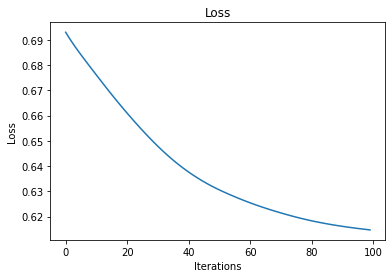

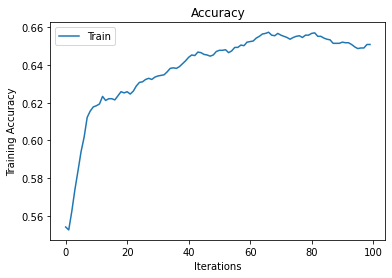

Final Training Accuracy: 0.6508181537511578


In [69]:
def get_accuracy(X, y):
  output = lstm1(X)
  y = y.squeeze()
  pred = output.max(1)[1]
  correct = np.count_nonzero(y.eq(output.max(1)[1]))
  total = X.shape[0]
  res = correct/total
  return res

criterion = torch.nn.CrossEntropyLoss() #Mean squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)
iters, losses, train_acc, = [], [], []

for epoch in range(num_epochs):
  ouputs = lstm1(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #calculate the gradient, mnually set to 0y_test_tensors_final
  #print(f"Ouput: {ouputs} and Y:{y_train_tensors_final.squeeze().long()}")
  #break
  loss = criterion(ouputs, y_train_tensors_final.squeeze().long()) #obtain loss function
  loss.backward() #compute loss
  optimizer.step() #imporve from loss #backprop
  # print(f"Epoch: {epoch}, loss:{loss.item()}")

  iters.append(epoch)
  losses.append(float(loss))             # compute *average* loss
  train_acc.append(get_accuracy(X_train_tensors_final, y_train_tensors_final)) # compute training accuracy 
  print(f"Epoch {epoch+1}: Train acc: {train_acc[epoch]} Losses: {losses[epoch]}")

# plotting
plt.title("Loss")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

plt.title("Accuracy")
plt.plot(iters, train_acc, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

print("Final Training Accuracy: {}".format(train_acc[-1]))

Testing